In [ ]:
# import bread & butter
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import date



plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 20, 10






In [2]:

#Get ticker prices using ALPHAVANTAGE API (Note: Tried Quandl first but they haven't updated their data since 03/27/2018. See here for details https://github.com/quantopian/zipline/issues/2145)
apple_api_query = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=C4NAJ99Y5APM920K&datatype=csv'
msft_api_query  = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=C4NAJ99Y5APM920K&datatype=csv'
apple_df = pd.read_csv(apple_api_query,parse_dates=['timestamp'])
msft_df = pd.read_csv(msft_api_query,parse_dates=['timestamp'])


#filter the duration we'd like to show
start_date = '2010-01-25'
end_date   ='2018-11-28'
apple_df = apple_df[(apple_df.timestamp>=start_date) & (apple_df.timestamp<=end_date)]
msft_df = msft_df[(msft_df.timestamp>=start_date) & (msft_df.timestamp<=end_date)]

In [3]:
#Get historical Outstanding shares using  https://www.sharesoutstandinghistory.com
apple_hist_os_shares = pd.read_csv('APPLE_OS_SHARES.csv',parse_dates=['DATE'])
msft_hist_os_shares = pd.read_csv('MSFT_OS_SHARES.csv',parse_dates=['DATE'])

#add end date
apple_hist_os_shares['end_date'] = apple_hist_os_shares['DATE'].shift(-1) + pd.DateOffset(-1)
apple_hist_os_shares.loc[apple_hist_os_shares.DATE == max(apple_hist_os_shares.DATE),'end_date']='2099-12-31 00:00:00'

msft_hist_os_shares['end_date'] = msft_hist_os_shares['DATE'].shift(-1) + pd.DateOffset(-1)
msft_hist_os_shares.loc[msft_hist_os_shares.DATE == max(msft_hist_os_shares.DATE),'end_date']='2099-12-31 00:00:00'

In [4]:
#Get the number of historical outstanding makrket shares based on date
for start_date, end_date,os_shares in zip(apple_hist_os_shares.DATE.values, apple_hist_os_shares.end_date.values,apple_hist_os_shares.AAPL_OS_SHARES):
    apple_df.loc[(apple_df.timestamp>=start_date)&(apple_df.timestamp<=end_date),'OS_SHARES'] = os_shares
    
for start_date, end_date,os_shares in zip(msft_hist_os_shares.DATE.values, msft_hist_os_shares.end_date.values,msft_hist_os_shares.MSFT_OS_SHARES):
    msft_df.loc[(msft_df.timestamp>=start_date)&(msft_df.timestamp<=end_date),'OS_SHARES'] = os_shares    
    

In [5]:
#account for Apple's 7:1 split on 6/6/2014
apple_df.loc[apple_df.timestamp<='2014-06-06','close'] = apple_df['close']/7

In [6]:
#Merge the two together
merged_df = pd.merge(msft_df,apple_df,left_on=['timestamp'],right_on=['timestamp'],how='inner',suffixes=('_MSFT', '_AAPL'))
final_df  = merged_df[['timestamp','close_AAPL','OS_SHARES_AAPL','close_MSFT','OS_SHARES_MSFT']]

#Calculate Mkt_Capital=Number of Outstanding shares * Closing price of share
final_df['MKT_CAP_AAPL']=final_df['close_AAPL'] * final_df['OS_SHARES_AAPL'] 
final_df['MKT_CAP_MSFT']=final_df['close_MSFT'] * final_df['OS_SHARES_MSFT'] 


C:\Users\sphulse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sphulse\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


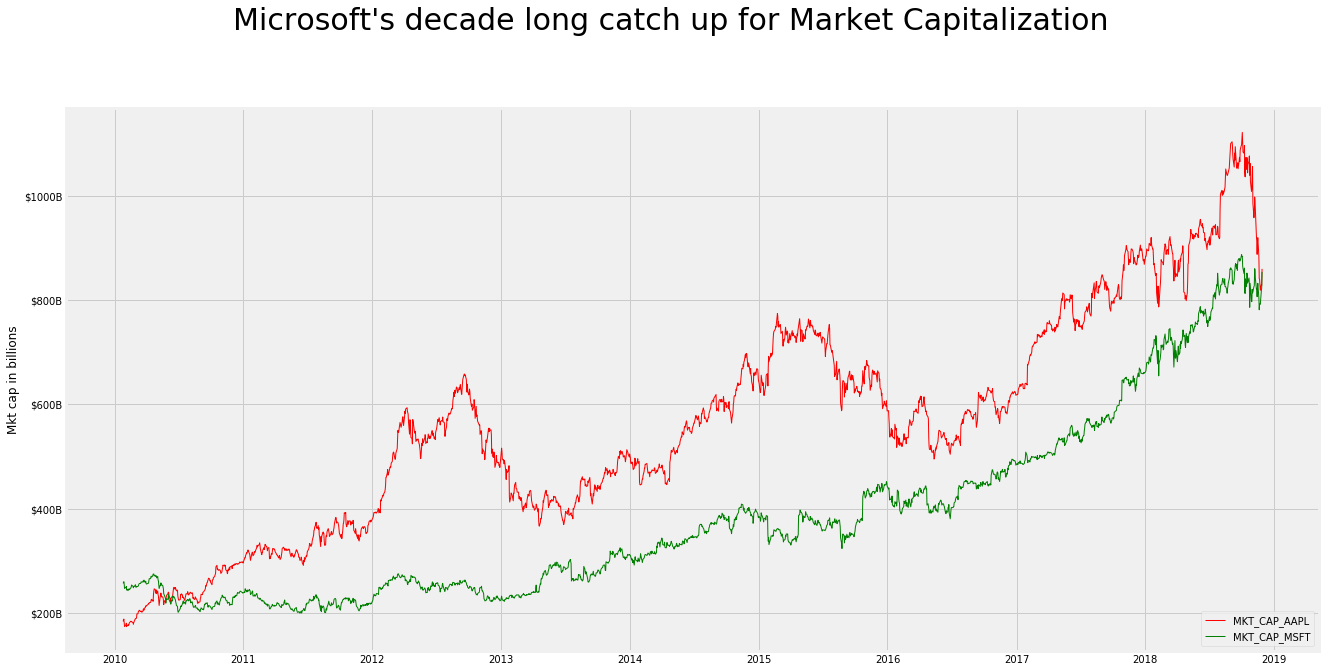

In [7]:

#PLot & save the trend chart
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fB' % (x*1e-9)))

plt.plot( 'timestamp', 'MKT_CAP_AAPL', data=final_df, marker=' ', markerfacecolor='blue', markersize=8, color='red', linewidth=1)
plt.plot( 'timestamp', 'MKT_CAP_MSFT', data=final_df, marker=' ', markerfacecolor='red', markersize=8, color='green', linewidth=1)
plt.legend(loc='lower right')
plt.ylabel('Mkt cap in billions')
#plt.xlabel('Years')

fig.suptitle('Microsoft\'s decade long catch up for Market Capitalization',ha='center',va='bottom',fontsize=30,fontweight=2)
#plt.savefig('Microsoft Vs Apple.png', bbox_inches='tight')
plt.savefig('destination_path.eps', format='eps', dpi=1000)